<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/PAMAP2/PAMAP_Multipath_CNN_inception_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
DATA_PATH ='/content/drive/MyDrive/datasets/PAMAP2_integrated_data.csv'

In [6]:
df = pd.read_csv(DATA_PATH, low_memory=False)
print(df.shape)
df.head()

(3850505, 55)


,timestamp,activityID,heart_rate,hand_temp,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_acc_6g_x,hand_acc_6g_y,hand_acc_6g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_mag_x,hand_mag_y,hand_mag_z,hand_orient_1,hand_orient_2,hand_orient_3,hand_orient_4,chest_temp,chest_acc_16g_x,chest_acc_16g_y,chest_acc_16g_z,chest_acc_6g_x,chest_acc_6g_y,chest_acc_6g_z,chest_gyro_x,chest_gyro_y,chest_gyro_z,chest_mag_x,chest_mag_y,chest_mag_z,chest_orient_1,chest_orient_2,chest_orient_3,chest_orient_4,ankle_temp,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z,ankle_acc_6g_x,ankle_acc_6g_y,ankle_acc_6g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_orient_1,ankle_orient_2,ankle_orient_3,ankle_orient_4,subject
0,8.38,0.0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,1.0,0.0,0.0,0.0,31.8125,0.238080,9.80003,-1.68896,0.265304,9.81549,-1.41344,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,1.0,0.0,0.0,0.0,30.3125,9.65918,-1.65569,-0.099797,9.64689,-1.55576,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,Protocol_subject101
1,8.39,0.0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,-0.024413,0.047759,0.006474,14.8991,-69.2224,-5.82311,1.0,0.0,0.0,0.0,31.8125,0.319530,9.61282,-1.49328,0.234939,9.78539,-1.42846,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,1.0,0.0,0.0,0.0,30.3125,9.69370,-1.57902,-0.215687,9.61670,-1.61630,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,Protocol_subject101
2,8.40,0.0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,1.0,0.0,0.0,0.0,31.8125,0.235593,9.72421,-1.76621,0.173850,9.72528,-1.51894,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,1.0,0.0,0.0,0.0,30.3125,9.58944,-1.73276,0.092914,9.63173,-1.58605,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,Protocol_subject101
3,8.41,0.0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,1.0,0.0,0.0,0.0,31.8125,0.388697,9.53572,-1.72410,0.157969,9.64994,-1.57952,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,1.0,0.0,0.0,0.0,30.3125,9.58814,-1.77040,0.054545,9.63197,-1.63135,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,Protocol_subject101
4,8.42,0.0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,1.0,0.0,0.0,0.0,31.8125,0.315800,9.49908,-1.60914,0.233506,9.57411,-1.44418,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,1.0,0.0,0.0,0.0,30.3125,9.69771,-1.65625,-0.060809,9.64699,-1.64647,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,Protocol_subject101


In [7]:
df.columns.tolist()

['timestamp',
 'activityID',
 'heart_rate',
 'hand_temp',
 'hand_acc_16g_x',
 'hand_acc_16g_y',
 'hand_acc_16g_z',
 'hand_acc_6g_x',
 'hand_acc_6g_y',
 'hand_acc_6g_z',
 'hand_gyro_x',
 'hand_gyro_y',
 'hand_gyro_z',
 'hand_mag_x',
 'hand_mag_y',
 'hand_mag_z',
 'hand_orient_1',
 'hand_orient_2',
 'hand_orient_3',
 'hand_orient_4',
 'chest_temp',
 'chest_acc_16g_x',
 'chest_acc_16g_y',
 'chest_acc_16g_z',
 'chest_acc_6g_x',
 'chest_acc_6g_y',
 'chest_acc_6g_z',
 'chest_gyro_x',
 'chest_gyro_y',
 'chest_gyro_z',
 'chest_mag_x',
 'chest_mag_y',
 'chest_mag_z',
 'chest_orient_1',
 'chest_orient_2',
 'chest_orient_3',
 'chest_orient_4',
 'ankle_temp',
 'ankle_acc_16g_x',
 'ankle_acc_16g_y',
 'ankle_acc_16g_z',
 'ankle_acc_6g_x',
 'ankle_acc_6g_y',
 'ankle_acc_6g_z',
 'ankle_gyro_x',
 'ankle_gyro_y',
 'ankle_gyro_z',
 'ankle_mag_x',
 'ankle_mag_y',
 'ankle_mag_z',
 'ankle_orient_1',
 'ankle_orient_2',
 'ankle_orient_3',
 'ankle_orient_4',
 'subject']

In [8]:
columns = [
    "activityID",
    "hand_temp", "hand_acc_6g_x", "hand_acc_6g_y", "hand_acc_6g_z",
    "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
    "hand_mag_x", "hand_mag_y", "hand_mag_z",
    "chest_temp", "chest_acc_6g_x", "chest_acc_6g_y", "chest_acc_6g_z",
    "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
    "chest_mag_x", "chest_mag_y", "chest_mag_z",
    "ankle_temp", "ankle_acc_6g_x", "ankle_acc_6g_y", "ankle_acc_6g_z",
    "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
    "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
]

In [9]:
df = df[columns].copy()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850505 entries, 0 to 3850504
Data columns (total 31 columns):
 #   Column          Dtype  
---  ------          -----  
 0   activityID      float64
 1   hand_temp       float64
 2   hand_acc_6g_x   float64
 3   hand_acc_6g_y   float64
 4   hand_acc_6g_z   float64
 5   hand_gyro_x     float64
 6   hand_gyro_y     float64
 7   hand_gyro_z     float64
 8   hand_mag_x      float64
 9   hand_mag_y      float64
 10  hand_mag_z      float64
 11  chest_temp      float64
 12  chest_acc_6g_x  float64
 13  chest_acc_6g_y  float64
 14  chest_acc_6g_z  float64
 15  chest_gyro_x    float64
 16  chest_gyro_y    float64
 17  chest_gyro_z    float64
 18  chest_mag_x     float64
 19  chest_mag_y     float64
 20  chest_mag_z     float64
 21  ankle_temp      float64
 22  ankle_acc_6g_x  float64
 23  ankle_acc_6g_y  float64
 24  ankle_acc_6g_z  float64
 25  ankle_gyro_x    float64
 26  ankle_gyro_y    float64
 27  ankle_gyro_z    float64
 28  ankle_mag_x 

In [10]:
feature_cols = [c for c in df.columns if c != "activityID"]

# activityID별로 NaN을 ffill -> bfill
df[feature_cols] = (
    df.groupby("activityID")[feature_cols]
      .transform(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
)

# 아직도 NaN이 남아있으면 그냥 드랍
before_drop = len(df)
df = df.dropna(subset=feature_cols + ["activityID"])
after_drop = len(df)

print("NaN 드랍 전:", before_drop, " / 이후:", after_drop)
df.head()


/tmp/ipython-input-3940382132.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
/tmp/ipython-input-3940382132.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method="ffill").fillna(method="bfill"))


NaN 드랍 전: 3850505  / 이후: 3850505


,activityID,hand_temp,hand_acc_6g_x,hand_acc_6g_y,hand_acc_6g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_mag_x,hand_mag_y,hand_mag_z,chest_temp,chest_acc_6g_x,chest_acc_6g_y,chest_acc_6g_z,chest_gyro_x,chest_gyro_y,chest_gyro_z,chest_mag_x,chest_mag_y,chest_mag_z,ankle_temp,ankle_acc_6g_x,ankle_acc_6g_y,ankle_acc_6g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z
0,0.0,30.0,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,31.8125,0.265304,9.81549,-1.41344,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,30.3125,9.64689,-1.55576,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438
1,0.0,30.0,2.39494,8.55081,3.64207,-0.024413,0.047759,0.006474,14.8991,-69.2224,-5.82311,31.8125,0.234939,9.78539,-1.42846,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,30.3125,9.61670,-1.61630,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253
2,0.0,30.0,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,31.8125,0.173850,9.72528,-1.51894,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,30.3125,9.63173,-1.58605,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999
3,0.0,30.0,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,31.8125,0.157969,9.64994,-1.57952,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,30.3125,9.63197,-1.63135,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956
4,0.0,30.0,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,31.8125,0.233506,9.57411,-1.44418,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,30.3125,9.64699,-1.64647,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694


In [11]:
#스케일링 (신호 데이터이므로 MinMaxScaler로 스케일링)
scaler = MinMaxScaler()

df[feature_cols] = scaler.fit_transform(df[feature_cols].astype(np.float32))

print(df[feature_cols].describe().T.head())


                   count      mean       std  ...       50%       75%  max
hand_temp      3850505.0  0.748372  0.176804  ...  0.789773  0.875000  1.0
hand_acc_6g_x  3850505.0  0.463852  0.049193  ...  0.461320  0.498460  1.0
hand_acc_6g_y  3850505.0  0.528089  0.047763  ...  0.528417  0.555163  1.0
hand_acc_6g_z  3850505.0  0.529590  0.032749  ...  0.527469  0.554037  1.0
hand_gyro_x    3850505.0  0.515706  0.024739  ...  0.515654  0.520421  1.0

[5 rows x 8 columns]


In [12]:
#윈도우 생성 함수
def create_sliding_windows(features, labels, window_size=200, step_size=100):
    """
    features: (N, num_features)
    labels:   (N,)
    return:   X: (num_seq, window_size, num_features)
              y: (num_seq,)
    """
    X_windows = []
    y_windows = []

    num_samples = len(features)

    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window_x = features[start:end]

        # window 안 label 중 최빈값을 사용 (activity가 섞여도 대충 majority)
        window_labels = labels[start:end]
        # np.bincount 사용하려면 label이 non-negative integer여야 함
        most_common_label = np.bincount(window_labels).argmax()

        X_windows.append(window_x)
        y_windows.append(most_common_label)

    X_windows = np.array(X_windows, dtype=np.float32)
    y_windows = np.array(y_windows, dtype=np.int64)

    return X_windows, y_windows

In [13]:
# numpy로 변환
all_features = df[feature_cols].values.astype(np.float32)
all_labels = df["activityID"].values.astype(int)

print("전체 feature shape:", all_features.shape)  # (N, 33)
print("전체 label shape:", all_labels.shape)

# 윈도우 파라미터
WINDOW_SIZE = 200  # 2초
STEP_SIZE = 100    # 1초 간격 (50% overlap)

X, y_raw = create_sliding_windows(
    all_features,
    all_labels,
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE
)

print("윈도우 X shape:", X.shape)  # (num_seq, 200, 33)
print("윈도우 y_raw shape:", y_raw.shape)


전체 feature shape: (3850505, 30)
전체 label shape: (3850505,)
윈도우 X shape: (38504, 200, 30)
윈도우 y_raw shape: (38504,)


In [14]:
#라벨 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

num_classes = len(label_encoder.classes_)
num_features = X.shape[2]
print("클래스 개수:", num_classes)
print("feature 개수:", num_features)
print("클래스 목록(activityID 원래 값):", label_encoder.classes_)


클래스 개수: 19
feature 개수: 30
클래스 목록(activityID 원래 값): [ 0  1  2  3  4  5  6  7  9 10 11 12 13 16 17 18 19 20 24]


In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.2,            # 20% test
    random_state=RANDOM_SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_train_val
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (24642, 200, 30) (24642,)
Val  : (6161, 200, 30) (6161,)
Test : (7701, 200, 30) (7701,)


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def inception_module(input_tensor, filters):
  #병목 레이어
  bottleneck=layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(input_tensor)
  conv3=layers.Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu')(bottleneck)
  conv5=layers.Conv1D(filters=filters, kernel_size=5, padding='same', activation='relu')(bottleneck)
  conv7=layers.Conv1D(filters=filters, kernel_size=7, padding='same', activation='relu')(bottleneck)

  maxpool=layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
  maxpool_conv=layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(maxpool)

  x=layers.Concatenate(axis=2)([conv3, conv5, conv7, maxpool_conv])
  x=layers.BatchNormalization()(x)
  return x

In [43]:
def build_inception_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = inception_module(inputs, filters=32)
    x = layers.Dropout(0.3)(x)
    x = layers.MaxPooling1D(pool_size=2)(x) # 시간 차원 절반으로 축소

    x = inception_module(x, filters=64)
    x = layers.Dropout(0.3)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    residual = layers.Conv1D(filters=64*4, kernel_size=1, padding='same')(x)
    block_out = inception_module(x, filters=64)

    x = layers.Add()([block_out, residual])
    x = layers.Activation('relu')(x)
    x=layers.Dropout(0.3)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # --- Classification Head ---
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Inception_CNN_1D")
    return model

In [44]:
input_shape = (WINDOW_SIZE, num_features) # (200, 30)
inception_model = build_inception_model(input_shape, num_classes)

inception_model.summary()

Model: "Inception_CNN_1D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200, 30)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 200, 32)   │        992 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 200, 30)   │          0 │ input_layer_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 200, 32)   │      3,104 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 200, 32)   │      5,152 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 200, 32)   │      7,200 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 200, 32)   │        992 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 200, 128)  │          0 │ conv1d_33[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_35[0][0],  │
│                     │                   │            │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 128)  │        512 │ concatenate_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 200, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 100, 128)  │          0 │ dropout_6[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 100, 64)   │      8,256 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 100, 128)  │          0 │ max_pooling1d_13… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 100, 64)   │     12,352 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 100, 64)   │     20,544 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 100, 64)   │     28,736 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 100, 64)   │      8,256 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 100, 256)  │          0 │ conv1d_38[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_39[0][0],  │
│                     │                   │            │ conv1d_40[0][0],  │
│                     │                   │            │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 256)  │      1,024 │ concatenate_7[0]… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 293,811 (1.12 MB)

 Trainable params: 292,531 (1.12 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [45]:
inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
    )
]

history_inc = inception_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.4777 - loss: 1.8591 - val_accuracy: 0.2285 - val_loss: 2.9691 - learning_rate: 5.0000e-04
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7975 - loss: 0.6588 - val_accuracy: 0.2225 - val_loss: 3.4990 - learning_rate: 5.0000e-04
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8483 - loss: 0.4859 - val_accuracy: 0.4957 - val_loss: 2.0236 - learning_rate: 5.0000e-04
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8759 - loss: 0.3968 - val_accuracy: 0.6479 - val_loss: 1.1835 - learning_rate: 5.0000e-04
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8891 - loss: 0.3453 - val_accuracy: 0.6913 - val_loss: 0.9933 - learning_rate: 5.0000e-04
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9006 - loss: 0.3043 - val_accuracy: 0.6906 - val_loss: 0.9676 - learning_rate: 5.0000e-04
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - ac

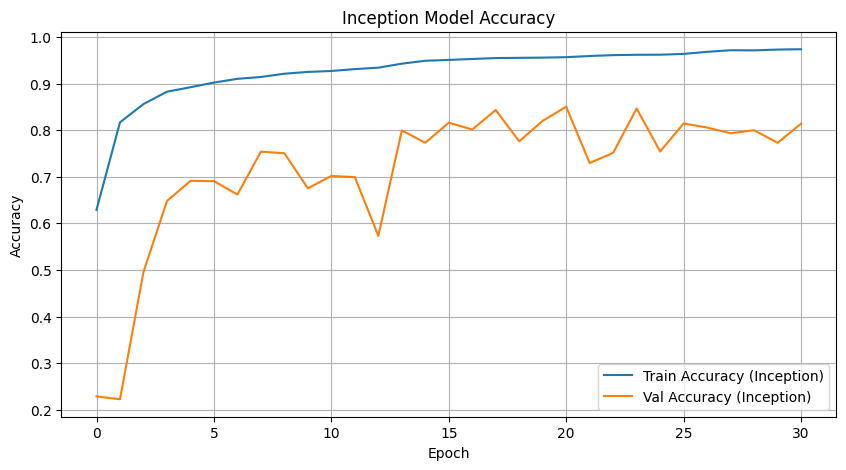

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history_inc.history['accuracy'], label='Train Accuracy (Inception)')
plt.plot(history_inc.history['val_accuracy'], label='Val Accuracy (Inception)')
plt.title('Inception Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


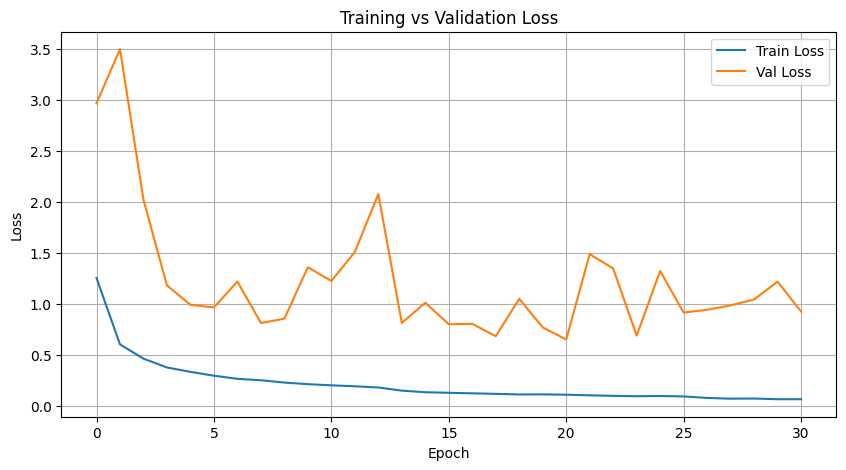

In [47]:
plt.figure(figsize=(10,5))
plt.plot(history_inc.history['loss'], label='Train Loss')
plt.plot(history_inc.history['val_loss'], label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
test_loss, test_acc = inception_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

Test Loss: 0.6739
Test Acc : 0.8398


In [49]:
y_pred_prob = inception_model.predict(X_test, verbose=0)
y_pred = y_pred_prob.argmax(axis=1)

In [50]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))


              precision    recall  f1-score   support

           0       0.69      0.95      0.80      2249
           1       0.98      0.83      0.90       386
           2       0.79      0.89      0.84       371
           3       0.86      0.67      0.75       380
           4       0.94      0.92      0.93       477
           5       1.00      0.96      0.98       196
           6       0.98      0.86      0.92       329
           7       0.99      0.91      0.95       376
           9       1.00      0.99      0.99       167
          10       0.97      0.98      0.98       620
          11       1.00      0.97      0.99       109
          12       0.97      0.33      0.49       234
          13       1.00      0.30      0.47       210
          16       0.83      0.71      0.76       351
          17       0.98      0.78      0.87       478
          18       0.89      0.74      0.81       200
          19       0.93      0.66      0.78       375
          20       1.00    

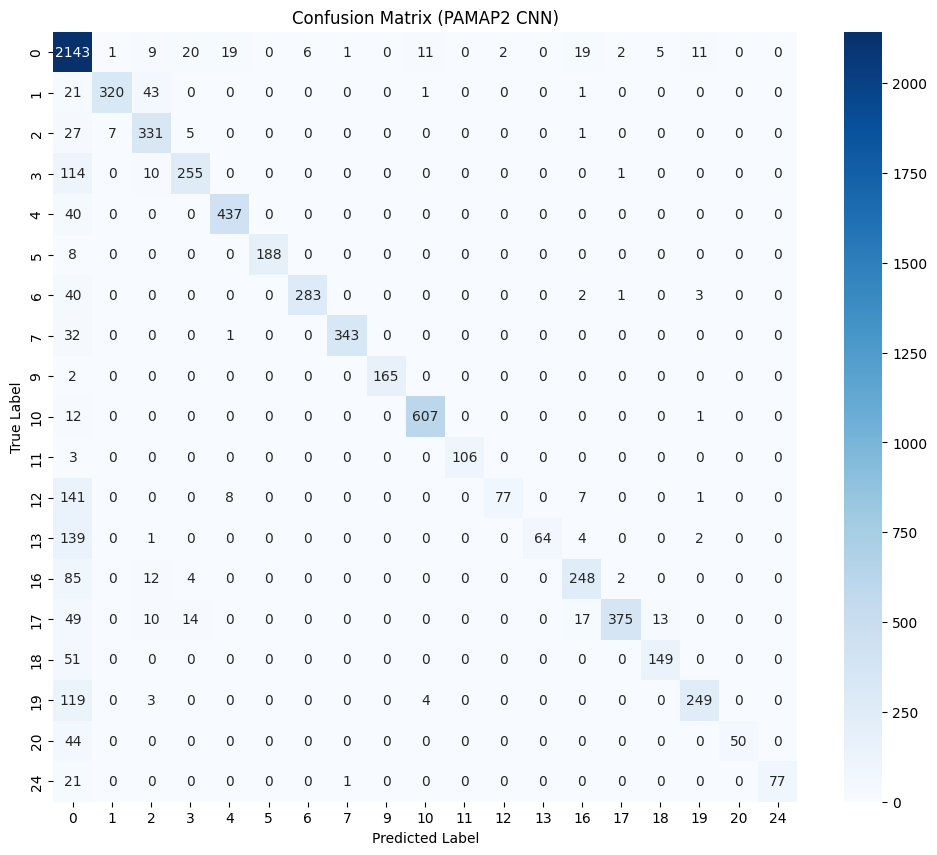

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (PAMAP2 CNN)")
plt.show()


In [51]:
#왜 성능이 안 오르는지? ㅜㅜ